In [1]:
import pandas as pd
import numpy as np
import os
import collections
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
plt.rcParams.update({"font.size":20})
pd.set_option('display.max_columns', 500)

In [3]:
%%time
train = pd.read_csv("../processed_data/fillna_with_mean.csv")

CPU times: user 3min 7s, sys: 39.6 s, total: 3min 47s
Wall time: 4min 9s


In [4]:
X = train[~train.isFraud.isna()].drop(["TransactionID", "isFraud"], axis="columns")
Y = train.loc[~train.isFraud.isna(), "isFraud"]
X_finaltest = train[train.isFraud.isna()].drop(["TransactionID", "isFraud"], axis="columns")
Y_finaltest = train.loc[train.isFraud.isna(), "TransactionID"]

In [7]:
del train

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

In [6]:
def confusion_matrix(y_true, y_pred):
    TP = sum((y_pred == 1) & (y_true == 1))
    TN = sum((y_pred == 0) & (y_true == 0))
    FP = sum((y_pred == 1) & (y_true == 0))
    FN = sum((y_pred == 0) & (y_true == 1))
    print("{}TP | {}FP\n-----------------\n{}FN | {}TN".format(TP, FP, FN, TN))
    
    recall = 1.0*TP/(TP+FN)
    precision = 1.0*TP/(TP+FP)
    accuracy = 1.0*(TP+TN)/(TP+FP+TN+FN)
    
    f1 = 2.0/ (1/recall + 1/precision)
    print("\naccuracy: {:.4}, recall: {:.4}, precision: {:.4}, F-1 score: {:.4}".format(accuracy, recall, precision, f1))
    return TP, TN, FP, FN, recall, precision, f1

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 23)

In [10]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

In [12]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
watchlist = [(dtest, "eval")]
params = {"booster": "gbtree",
        "objective": 'binary:logistic',
        'subsample': 0.8,
        'colsample_bytree': 0.85,
        'eta': 0.05,
        'max_depth': 7,
        'seed': 2016,
        'silent': 0,
        'eval_metric': 'rmse'
}
clf = xgb.train(params, dtrain, 500, watchlist, early_stopping_rounds=5)

[15:55:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[0]	eval-rmse:0.477556
Will train until eval-rmse hasn't improved in 50 rounds.
[15:55:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 182 extra nodes, 0 pruned nodes, max_depth=7
[1]	eval-rmse:0.456396
[15:55:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 184 extra nodes, 0 pruned nodes, max_depth=7
[2]	eval-rmse:0.436427
[15:56:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[3]	eval-rmse:0.417635
[15:56:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 196 extra nodes, 0 pruned nodes, max_depth=7
[4]	eval-rmse:0.399896
[15:56:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 178 extra nodes, 0 pruned nodes, max_depth=7
[5]	eval-rmse:0.383162
[15:56:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 190 extra nodes, 0 pruned nodes, max_depth=7
[6]	eval-rmse:

NameError: name 'df_test' is not defined

In [13]:
pred = clf.predict(xgb.DMatrix(X_test))

In [20]:
TP, TN, FP, FN, recall, precision, f1 = confusion_matrix(y_test, (pred>0.5))

2067TP | 133FP
-----------------
2083FN | 113825TN

accuracy: 0.9812, recall: 0.4981, precision: 0.9395, F-1 score: 0.651


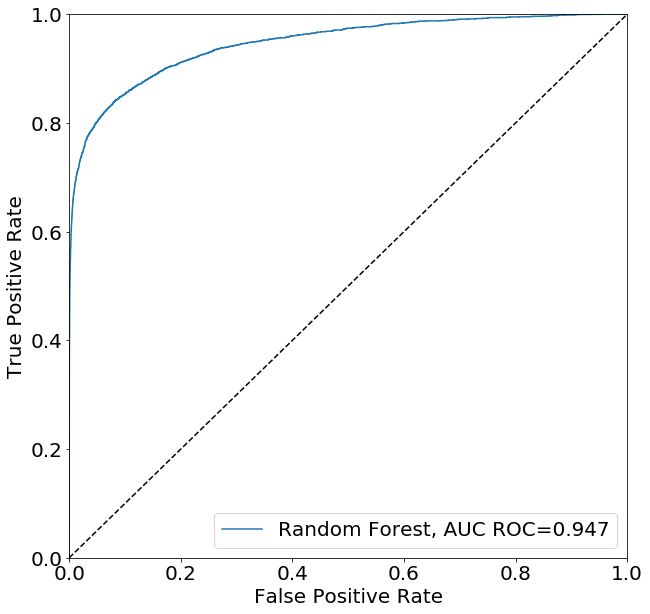

In [16]:
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test, pred)
plt.plot(fpr, tpr, label="Random Forest, AUC ROC={:.3}".format(roc_auc_score(y_test, pred)))
plt.axis([0,1,0,1])
plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

In [17]:
prob = clf.predict(xgb.DMatrix(X_finaltest))

In [19]:
pd.DataFrame({"TransactionID": Y_finaltest, "isFraud": prob}).to_csv("../submissions/xgb.csv", index=False)

In [21]:
clf.save_model("../models/basic_xgb_model")